
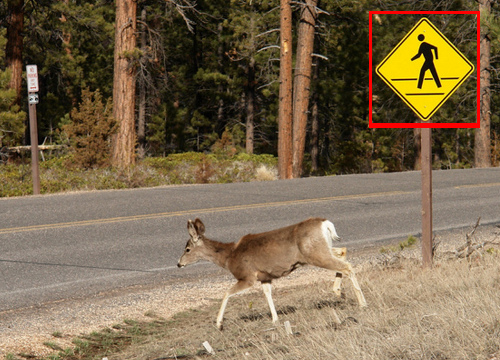

# Object Detection

In this assignment, you will develop an object detector based on gradient features and sliding window classification. A set of test images and ***hogvis.py*** are provided in the Canvas assignment directory

---

***Name:Mohammadarshya Salehibakhsh***

***SID: 71713160***

---

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math

#provided function for visualizing hog descriptors
from hogvis import hogvis

---
# 1. Image Gradients [10 pts]

Write a function that takes a grayscale image as input and returns two arrays the same size as the image, the first of which contains the magnitude of the image gradient at each pixel and the second containing the orientation.

Your function should filter the image with the simple x- and y-derivative filters described in class. To smooth the image you can use ***scipy.ndimage.gaussian_filter*** with ***sigma=0.5***. You can use  ***scipy.ndimage.correlate*** with the 'nearest' option in order to nicely handle the image boundaries. Once you have the derivatives you can compute the orientation and magnitude of the gradient vector at each pixel. 

Include a visualization of the output of your gradient calculate for a small test image. For displaying the orientation result, please uses a cyclic colormap such as "hsv" (see https://matplotlib.org/tutorials/colors/colormaps.html)

NOTE: To be consistent with the provided code that follows, the gradient orientation values you return should range in (-pi/2,+pi/2) where a horizontal edge (vertical gradient) has an orientation of -pi/2 and the angle increases as the edge rotates clockwise in the image.

In [32]:
#we will only use:  scipy.ndimage.correlate and ndimage.gaussian_filter
from scipy import ndimage

def mygradient(image):
    """
    This function takes a grayscale image and returns two arrays of the
    same size, one containing the magnitude of the gradient, the second
    containing the orientation of the gradient.
    
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    Returns
    -------
    mag : 2D float array of shape HxW
        gradient magnitudes
        
    ori : 2Dfloat array of shape HxW
        gradient orientations in radians
    """
    
    # we will use symmetric derivative filters to compute the gradient
    # but the simple filter from class, [-1,1] works just as well.
    sigma=0.5
    horz = np.array([[-1,0, 1]])
    vert = np.array([[-1,0, 1]]).transpose()

    # your code goes here
    smoothed=ndimage.gaussian_filter(image, sigma=sigma)

    # Compute gradients using correlation
    grad_x = ndimage.correlate(smoothed, horz, mode='nearest')
    grad_y = ndimage.correlate(smoothed, vert, mode='nearest')
    
    # Compute gradient magnitude and orientation
    mag = np.sqrt(grad_x**2 + grad_y**2)
    ori = np.arctan2(grad_y, grad_x)  # Orientation in range [-pi, pi]
    
    # Adjust orientation to be in the range [-pi/2, pi/2]
    ori = np.mod(ori + np.pi/2, np.pi) - np.pi/2
    
    return (mag,ori)

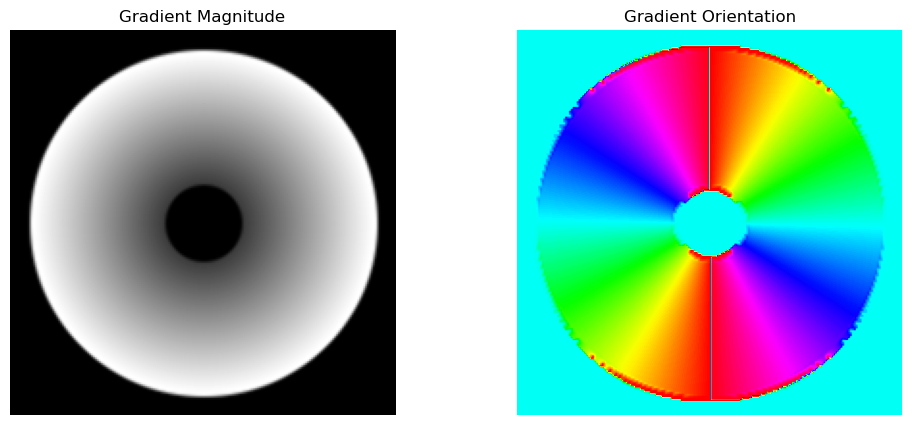

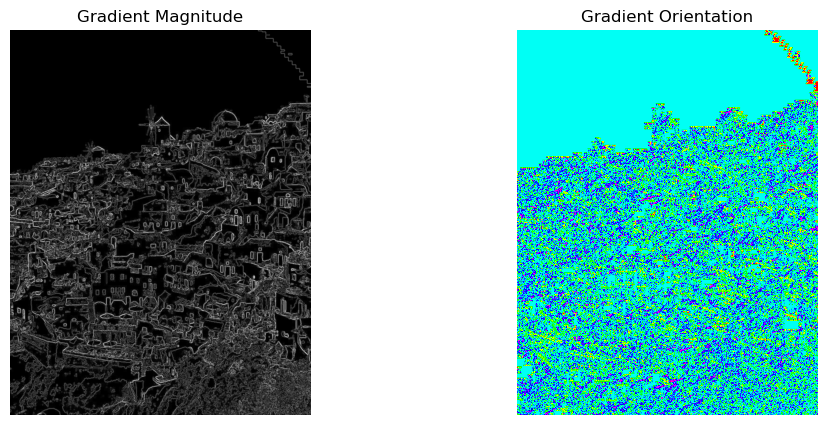

In [33]:
#
# Demonstrate your mygradient function here by loading in a grayscale
# image, calling mygradient, and visualizing the resulting magnitude
# and orientation images. For visualizing orientation image, I suggest 
# using the hsv colormap.
#
# here is one simple test image which has gradients pointed in all 
# directions so you can see if your orientation estimates are reasonable
from matplotlib.image import imread

[yy,xx] = np.mgrid[-100:100,-100:100]
testimage = np.minimum(np.maximum(np.array(xx*xx+yy*yy,dtype=float),400),8100)

# you should also load in or synthesize another image to test with besides
# the one above.
image = imread('grayscale.jpg')
if image.ndim == 3:
    image = np.mean(image, axis=-1)  # Convert to grayscale if needed

(mag,ori) = mygradient(testimage)

#visualize results mag,ori as images
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(mag, cmap='gray')
ax[0].set_title('Gradient Magnitude')
ax[0].axis('off')

ax[1].imshow(ori, cmap='hsv')
ax[1].set_title('Gradient Orientation')
ax[1].axis('off')

plt.show()

(mag,ori)= mygradient(image)

#visualize results mag,ori as images
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(mag, cmap='gray')
ax[0].set_title('Gradient Magnitude')
ax[0].axis('off')

ax[1].imshow(ori, cmap='hsv')
ax[1].set_title('Gradient Orientation')
ax[1].axis('off')

plt.show()


---

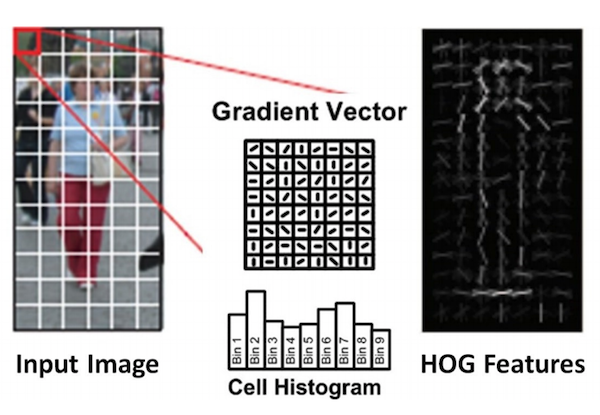

# 2. Histograms of Gradient Orientations [20 pts]

Write a function that computes gradient orientation histograms over each 8x8 block of pixels in an image. Your function should bin the orientation into 9 equal sized bins between -pi/2 and pi/2. The input of your function will be an image of size HxW. The output should be a three-dimensional array ***ohist*** whose size is (H/8)x(W/8)x9 where ***ohist[i,j,k]*** contains the count of how many edges of orientation k fell in block (i,j). If the input image dimensions are not a multiple of 8, you should use ***np.pad*** with the ***mode=edge*** option to pad the width and height up to the nearest integer multiple of 8.

To determine if a pixel is an edge, we need to choose some threshold. I suggest using a threshold that is 10% of the maximum gradient magnitude in the image. Since each 8x8 block will contain a different number of edges, you should normalize the resulting histogram for each block to sum to 1 (i.e., ***np.sum(ohist,axis=2)*** should be 1 at every  location).

I would suggest your function loops over the orientation bins. For each orientation bin you'll need to identify those pixels in the image whose gradient magnitude is above the threshold and whose orientation falls in the given bin. You can do this easily in numpy using logical operations in order to generate an array the same size as the image that contains Trues at the locations of every edge pixel that falls in the given orientation bin and is above threshold. To collect up pixels in each 8x8 spatial block you can use the function ***ski.util.view_as_windows(...,(8,8),step=8)*** to extract all of the blocks then ***np.reshape*** and ***np.sum*** to count the number of edges in each block.

Test your code by creating a simple test image (e.g. a white disk on a black background), computing the descriptor and using the provided function ***hogvis*** to visualize it.

Note: in the discussion above I have assumed 8x8 block size and 9 orientations. In your code you should use the parameters ***bsize*** and ***norient*** in place of these constants.

In [34]:
#we will only use:  ski.util.view_as_windows for computing hog descriptor
import skimage as ski 

def hog(image,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and returns a 3D array
    containing the histogram of gradient orientations descriptor (HOG)
    We follow the convention that the histogram covers gradients starting
    with the first bin at -pi/2 and the last bin ending at pi/2.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values in [0,1]
    
    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
        
    Returns
    -------
    ohist : 3D float array of shape (H/bsize,W/bsize,norient)
        edge orientation histogram
        
    """   
    
    # determine the size of the HOG descriptor
    (h,w) = image.shape
    h2 = int(np.ceil(h/float(bsize)))
    w2 = int(np.ceil(w/float(bsize)))
    ohist = np.zeros((h2,w2,norient))
    
    # pad the input image on right and bottom as needed so that it 
    # is a multiple of bsize
    pw = (0, w2 * bsize - w) #amounts to pad on left and right side
    ph = (0, h2 * bsize - h) #amounts to pad on bottom and top side
    image = np.pad(image,(ph,pw),'constant')
    
    # make sure we did the padding correctly
    assert(image.shape==(h2*bsize,w2*bsize))
    
    # compute image gradients
    (mag,ori) = mygradient(image)
    
    # choose a threshold which is 10% of the maximum gradient magnitude in the image
    thresh = 0.1*np.max(mag)
    
    
    # separate out pixels into orientation channels, dividing the range of orientations
    # [-pi/2,pi/2] into norient equal sized bins and count how many fall in each block    
    binEdges = np.linspace(-np.pi/2, np.pi/2, norient+1)
    
    # as a sanity check, make sure every pixel gets assigned to at most 1 bin.
    bincount = np.zeros((h2*bsize,w2*bsize))   
    for i in range(norient):
        #create a binary image containing 1s for pixels at the ith 
        #orientation where the magnitude is above the threshold.
        B = (mag > thresh) & (ori >= binEdges[i]) & (ori < binEdges[i+1])
    
        #sanity check: record which pixels have been selected at this orientation
        bincount = bincount + B
        
        #pull out non-overlapping bsize x bsize blocks
        chblock = ski.util.view_as_windows(B,(bsize,bsize),step=bsize)
    
        #sum up the count for each block and store the results
        ...
        #ohist[:,:,i] = np.sum(np.sum(chblock, axis=2),axis=2)
        ohist[:,:,i] = np.sum(chblock, axis=(2, 3))
       
    #each pixel should have only selected at most once
    assert(np.all(bincount<=1))

    # lastly, normalize the histogram so that the sum along the orientation dimension is 1
    # note: don't divide by 0! If there are no edges in a block (i.e. the sum of counts
    # is 0) then your code should leave all the values as zero. 
    
    ...
    sums = np.sum(ohist, axis=2, keepdims=True)
    sums[sums == 0] = 1  # Avoid division by zero
    ohist /= sums
    
    
    assert(ohist.shape==(h2,w2,norient))
    
    return ohist

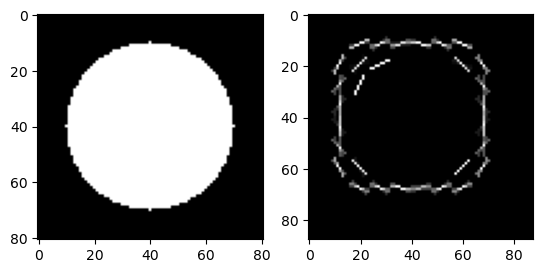

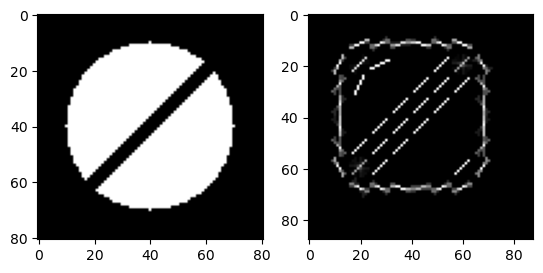

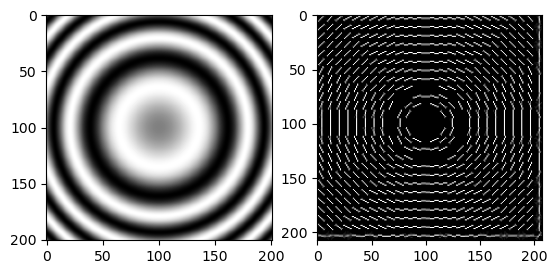

In [35]:
#provided function for visualizing hog descriptors
from hogvis import hogvis

#
# generate a simple test image... a 80x80 image
# with a circle of radius 30 in the center
#
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)

#
# display the image and the output of hogvis
#
ohist=hog(im)
hogim= hogvis(ohist)

plt.subplot(1,2,1)
plt.imshow(im,cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.imshow(hogim,cmap=plt.get_cmap('gray'))
plt.show()

# two other synthetic test images to experiment with
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)
im[np.abs(xx+yy)<=3] = 0

ohist=hog(im)
hogim= hogvis(ohist)

plt.subplot(1,2,1)
plt.imshow(im,cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.imshow(hogim,cmap=plt.get_cmap('gray'))
plt.show()



[yy,xx] = np.mgrid[-100:101,-100:101]
im = np.array(np.sin((xx*xx+yy*yy)/800),dtype=float)

ohist=hog(im)
hogim= hogvis(ohist)

plt.subplot(1,2,1)
plt.imshow(im,cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.imshow(hogim,cmap=plt.get_cmap('gray'))
plt.show()


---
# 3. Detection [25 pts]

Write a function that takes a template and an image and returns the top detections found in the image. Your function should follow the definition given below.

In your function you should first compute the histogram-of-gradient-orientation feature map for the image, then correlate the template with the feature map. Since the feature map and template are both three dimensional, you will want to filter each orientation separately and then sum up the results to get the final response. If the image of size HxW then this final response map will be of size (H/8)x(W/8).

When constructing the list of top detections, your code should implement non-maxima suppression so that it doesn't return overlapping detections. You can do this by sorting the responses in descending order of their score. Every time you add a detection to the list to return, check to make sure that the location of this detection is not too close to any of the detections already in the output list. You can estimate the overlap by computing the distance between a pair of detections and checking that the distance is greater than say 70% of the width of the template.

Your code should return the locations of the detections in terms of the original image pixel coordinates (so if your detector had a high response at block [i,j] in the response map, then you should return (8*i,8*j) as the pixel coordinates).

I have provided a function for visualizing the resulting detections which you can use to test your detect function. Please include some visualization of a simple test case.

In [36]:

#we will only use:  scipy.ndimage.correlate
from scipy import ndimage
from skimage import color

def detect(image,template,ndetect=5,bsize=8,norient=9):
    
    """    
    This function takes a grayscale image and a HOG template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values in [0,1]
    
    template : a 3D float array 
        The HOG template we wish to match to the image
        
    ndetect : int
        Maximum number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
    """
       
    # Ensure image is grayscale if it's RGB
    if len(image.shape) == 3:  # If the image is RGB
        image = color.rgb2gray(image)  # Convert to grayscale

    #visualize the input image and score response map
    vis=True
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==norient)
    
    fmap = hog(image,bsize=bsize,norient=norient)


    #nomilizing fmap
    fmap = (fmap - np.mean(fmap)) / (np.std(fmap) + 1e-6)
    
    #cross-correlate the template with the feature map to get the total response
    resp = np.zeros((fmap.shape[0],fmap.shape[1]))
    for i in range(norient):
        resp += ndimage.correlate(fmap[:, :, i], template[:, :, i])
        #, mode='constant'

    if np.max(resp) > np.min(resp):
        resp = (resp - np.min(resp)) / (np.max(resp) - np.min(resp))
    else:
        resp = np.zeros_like(resp)
    resp = (resp - np.min(resp)) / (np.max(resp) - np.min(resp))

    if vis:
        plt.subplot(1,2,1)
        plt.imshow(image,cmap=plt.get_cmap('gray'))
        plt.subplot(1,2,2)
        plt.imshow(resp)
        plt.show()
     
    #sort the values in resp in descending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]]
    # 
    ind = np.argsort(resp.ravel())[::-1]  #corresponding indices
    val = resp.ravel()[ind]  #sorted response values
    
    
    #work down the list of responses from high to low, to generate a 
    # list of ndetect top scoring matches which do not overlap
    detcount = 0
    i = 0
    detections = []
    
    template_h, template_w = template.shape[:2]
    min_dist = 0.5 * template_w * bsize

    while detcount < ndetect and i < len(val):
        # convert 1d index into 2d index
        yb, xb = np.unravel_index(ind[i], resp.shape)
    
        assert(val[i]==resp[yb,xb]) #make sure we did indexing correctly
        
        #covert block index to pixel coordinates based on bsize
        xp = xb * bsize
        yp = yb * bsize
    
        #check if this detection overlaps any detections that we've already added
        #to the list. compare the x,y coordinates of this detection to the x,y 
        #coordinates of the detections already in the list and see if any overlap
        #by checking if the distance between them is less than 70% of the template
        # width/height

        overlap = any(np.linalg.norm(np.array([xp, yp]) - np.array([x_prev, y_prev])) < min_dist 
                      for x_prev, y_prev, _ in detections)
    
        #...
        #overlap = False
        #for x_prev, y_prev, _ in detections:
            #xa, ya = max(x_prev, xp), max(y_prev, yp)
            #xb, yb = min(x_prev + template_w * bsize, xp + template_w * bsize), min(y_prev + template_h * bsize, yp + template_h * bsize)
            
            #inter_area = max(0, xb - xa) * max(0, yb - ya)
            #box1_area = (template_w * bsize) * (template_h * bsize)
            #box2_area = (template_w * bsize) * (template_h * bsize)
            #iou = inter_area / float(box1_area + box2_area - inter_area)
            
            #if iou > 0.3:  # Threshold for overlap suppression
                #overlap = True
                #break
        
        #if the detection doesn't overlap then add it to the list
        if not overlap:
            detections.append((xp,yp,val[i]))
            detcount = detcount + 1
        
        i=i+1
    

        
    return detections
    

In [37]:
import matplotlib.patches as patches

def plot_detections(image,detections,tsize_pix):
    """
    This is a utility function for visualization that takes an image and
    a list of detections and plots the detections overlayed on the image
    as boxes.
    
    Color of the bounding box is based on the order of the detection in
    the list, fading from green to red.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    detections : a list of tuples of length ndetect
        Detections are tuples (x,y,score)

    tsize_pix : (int,int)
        The height and width of the box in pixels
    
    Returns
    -------
    None
    
    """           
    ndetections = len(detections)
    
    plt.imshow(image,cmap=plt.cm.gray)
    ax = plt.gca()
    w = tsize_pix[1]
    h = tsize_pix[0]
    red = np.array([1,0,0])
    green = np.array([0,1,0])
    ct = 0
    for (x,y,score) in detections:
        xc = x-(w//2)
        yc = y-(h//2)
        col = (ct/ndetections)*red + (1-(ct/ndetections))*green
        rect = patches.Rectangle((xc,yc),w,h,linewidth=3,edgecolor=col,facecolor='none')
        ax.add_patch(rect)
        ct = ct + 1
        

    
    plt.show()

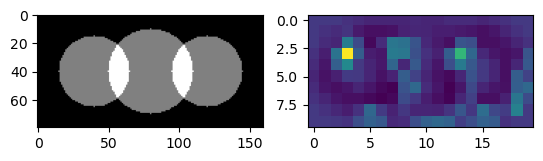

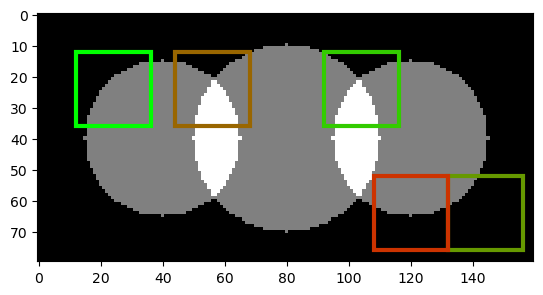

In [38]:
#
# sketch of some simple test code, modify as needed
#

#create a synthetic image with some overlapping circles
[yy,xx] = np.mgrid[-40:40,-80:80]
im1 = np.array((xx*xx+yy*yy<=30*30),dtype=float)
[yy,xx] = np.mgrid[-40:40,-40:120]
im2 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
[yy,xx] = np.mgrid[-40:40,-120:40]
im3 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
im = (1/3)*(im1+im2+im3)


#compute feature map with default parameters
fmap = hog(im)


#extract a 3x3 template
template = fmap[2:5,2:5,:]

# Normalize template 
template = (template - np.mean(template)) / (np.std(template) + 1e-6)

#run the detect code
detections = detect(im,template,ndetect=5)
    
#visualize results. 
plot_detections(im,detections,(3*8,3*8))

# visually confirm that:
#   1. top detection should be the same as the location where we selected the template
#   2. multiple detections do not overlap too much

---
# 4. Learning Templates [10 pts]

The final step is to implement a function to learn a template from positive and negative examples. Your code should take a collection of cropped positive and negative examples of the object you are interested in detecting, extract the features for each, and generate a template by taking the average positive template minus the average negative template.



In [39]:
from skimage.transform import resize

def learn_template(posfiles,negfiles,tsize=np.array([16,16]),bsize=8,norient=9):
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a HOG template and generates visualization
    of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks
    
    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9

    Returns
    -------
    template : float array of size tsize x norient
        The learned HOG template
    """
               
    
    #compute the template size in pixels 
    #corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    #figure to show positive training examples
    fig1 = plt.figure()
    pltct = 1

    #accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for i, file in enumerate(posfiles):
        #load in a cropped positive example
        img = imread(file)

        #convert to grayscale float in [0,1] and resize to fixed dimension tsize_pix
        #using skimage.transform.resize if needed.
        if img.ndim == 3:
                img = np.mean(img, axis=2)
                
        img_scaled = resize(img, tsize_pix, anti_aliasing=True)

        #display the example. if you want to train with a large # of examples, 
        #you may want to modify this, e.g. to show only the first 5.
        ax = fig1.add_subplot(len(posfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature
        fmap = hog(img_scaled)

        #compute running average
        pos_t += fmap

    #pos_t /= len(posfiles)
    pos_t = (1/len(posfiles))*pos_t
    fig1.show()
    
    # repeat same process for negative examples
    fig2 = plt.figure()
    pltct = 1  
    neg_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in negfiles:
        img = imread(file)
        if img.ndim == 3:
                img = np.mean(img, axis=2)
        img_scaled = resize(img, tsize_pix, anti_aliasing=True)
        ax = fig2.add_subplot(len(negfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        fmap = hog(img_scaled)
        neg_t += fmap
        

    #neg_t /= len(negfiles)
    neg_t = (1/len(negfiles))*neg_t
    fig2.show()

    # add code here to visualize the positive and negative parts of the template
    # using hogvis. you should separately visualize pos_t and neg_t rather than
    # the final template.
    # Visualize positive template
    fig3 = plt.figure()
    plt.title("Positive HOG Template")
    plt.imshow(hogvis(pos_t), cmap='gray')
    fig3.show()

    # Visualize negative template
    fig4 = plt.figure()
    plt.title("Negative HOG Template")
    plt.imshow(hogvis(neg_t), cmap='gray')
    fig4.show()
 

    # now construct our template as the average positive minus average negative
    template = pos_t - neg_t

    #print(f"Feature map shape: {fmap.shape}, Template shape: {template.shape}")
    #print(f"Feature map shape: {fmap.shape}, Template shape: {template.shape}")

    
    return template 


C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


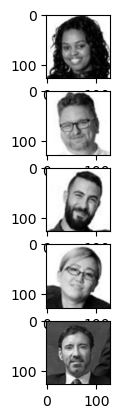

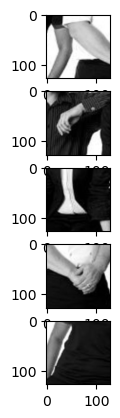

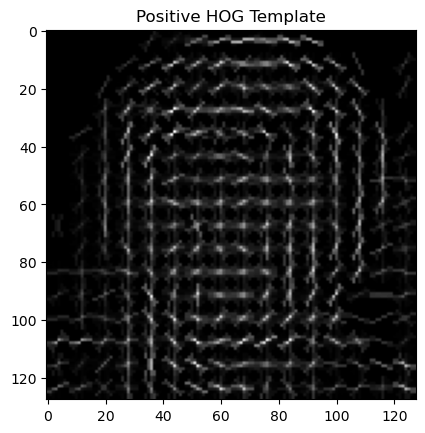

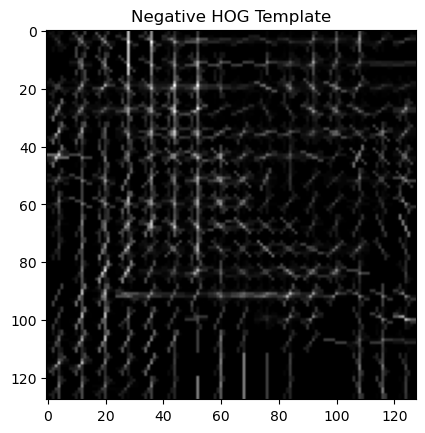

In [40]:
posfiles = ['pos1.jpg','pos2.jpg','pos3.jpg','pos4.jpg','pos5.jpg']
negfiles = ['neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg']

template = learn_template(posfiles, negfiles)

---
# 5. Experiments [15 pts]


Test your detection by training a template and running it on a test image.

In your experiments and writeup below you should include: (a) a visualization of the positive and negative patches you use to train the template and corresponding hog feature, (b) the detection results on the test image. You should show (a) and (b) for ***two different object categories***, the provided face test images and another category of your choosing (e.g. feel free to experiment with detecting cat faces, hands, cups, chairs or some other type of object).  Additionaly, please include results of testing your detector where there are at least 3 objects to detect (this could be either 3 test images which each have one or more objects, or a single image with many (more than 3) objects). Your test image(s) should be distinct from your training examples. Finally, write a brief (1 paragraph) discussion of where the detector works well and when it fails. Describe some ways you might be able to make it better.

NOTE 1: You will need to create the cropped test examples to pass to your ***learn_template***. You can do this by  cropping out the examples by hand (e.g. using an image editing tool). You should attempt to crop them out in the most consistent way possible, making sure that each example is centered with the same size and aspect ratio. Negative examples can be image patches that don't contain the object of interest. You should crop out negative examples with roughly the same resolution as the positive examples.

NOTE 2: Since we are not searching over scale, you will want to test on images where the object is the same size as your template. I recommend using the default ***bsize*** and ***norient*** parameters for all your experiments. You will likely want to modify the template size ***tsize*** as needed


## Experiment 1: Face detection

C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


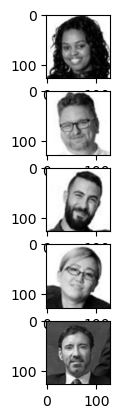

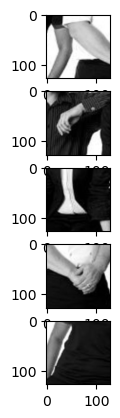

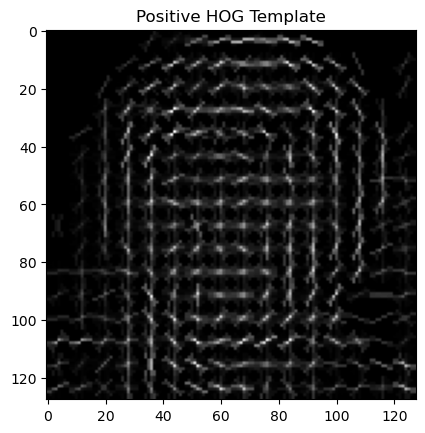

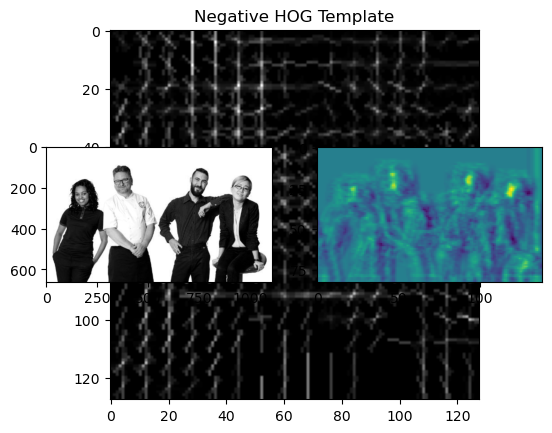

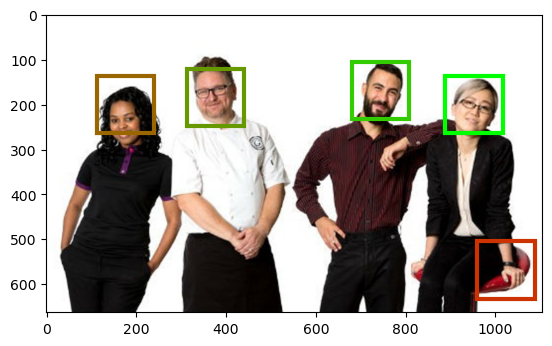

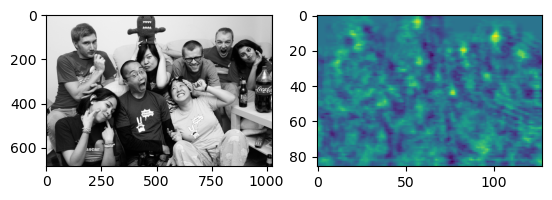

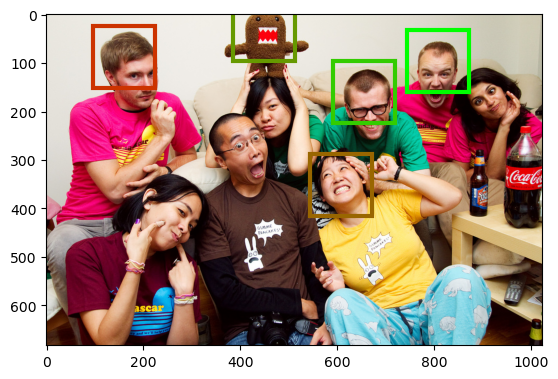

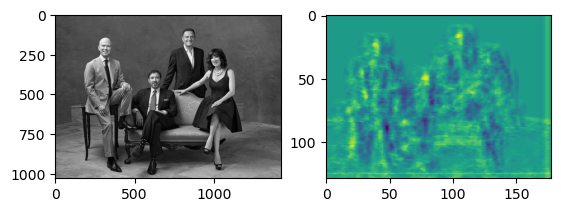

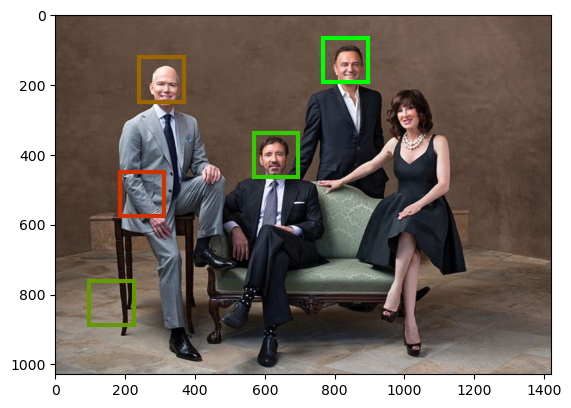

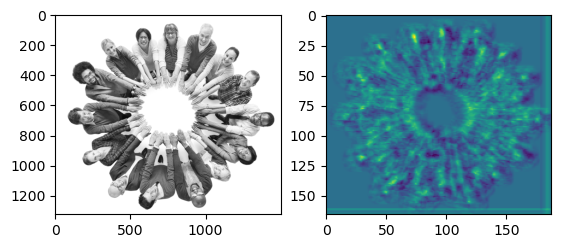

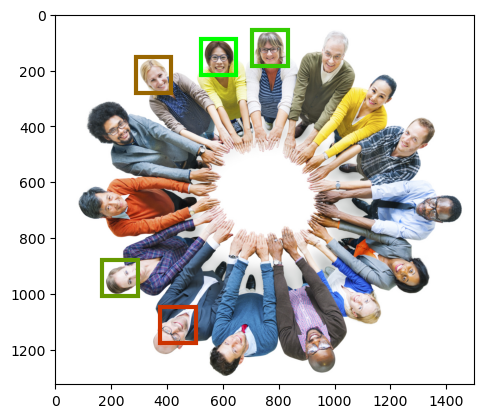

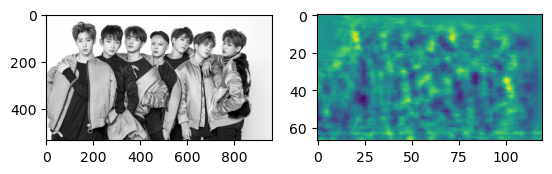

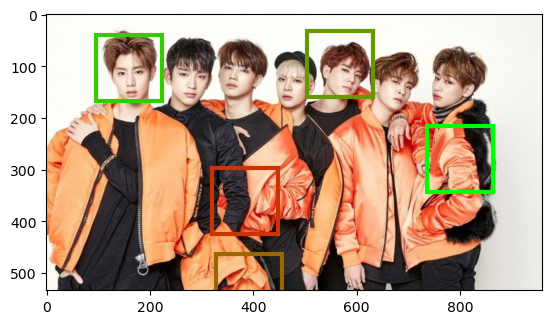

In [41]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos1.jpg','pos2.jpg','pos3.jpg','pos4.jpg','pos5.jpg')
negfiles = ('neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg')


# call learn_template to learn and visualize the template and training data
template=learn_template(posfiles,negfiles,tsize=tsize)

template = resize(template, fmap.shape, anti_aliasing=True)

# normelizing
template = (template - np.mean(template)) / (np.std(template) + 1e-6)

  
# call detect on one or more test images, visualizing the result with the plot_detections function

for i in range(5):
    im_test = plt.imread("faces" + str(i+1) + ".jpg").astype(float)/255
    detections = detect(im_test,template)
    plot_detections(im_test,detections,tsize_pix)


## Experiment 2: sign detection

C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\3301321345.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


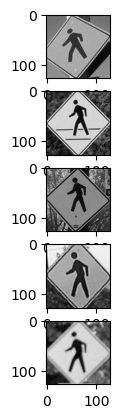

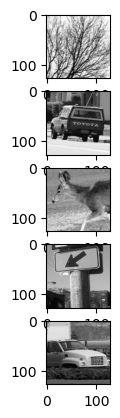

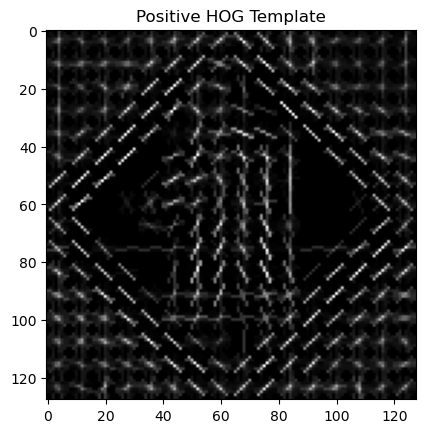

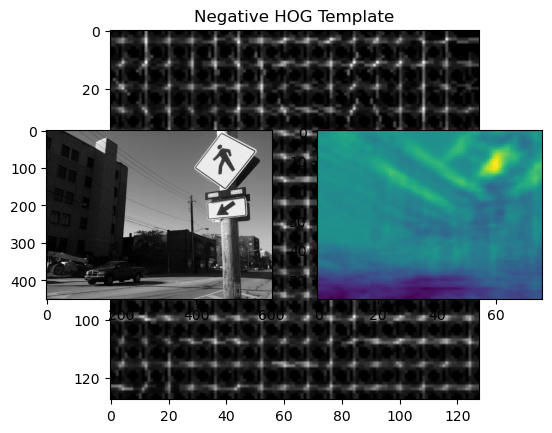

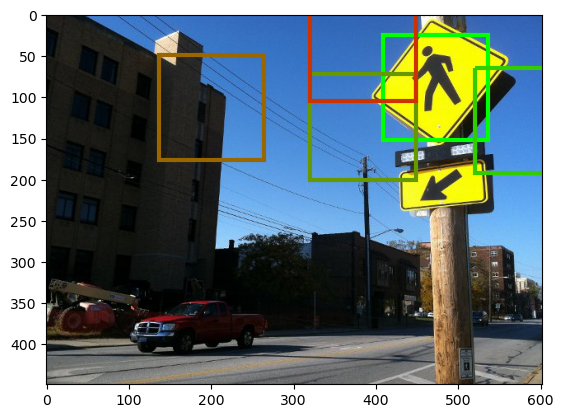

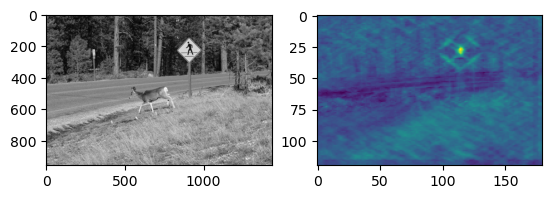

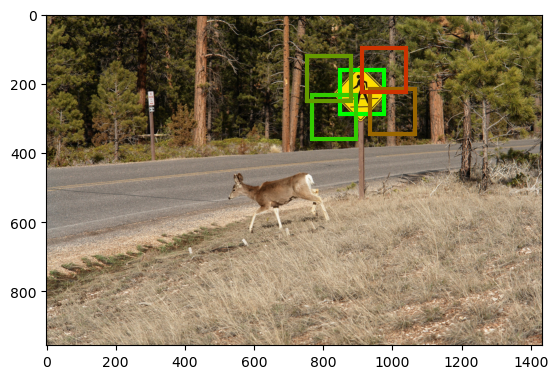

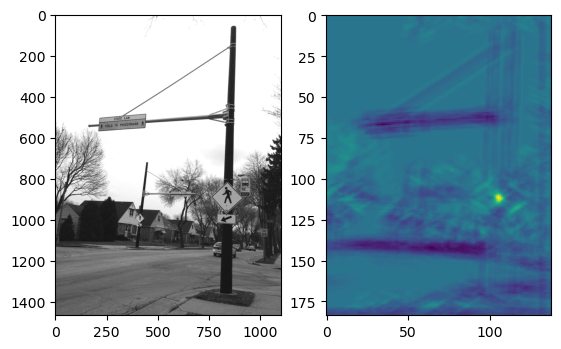

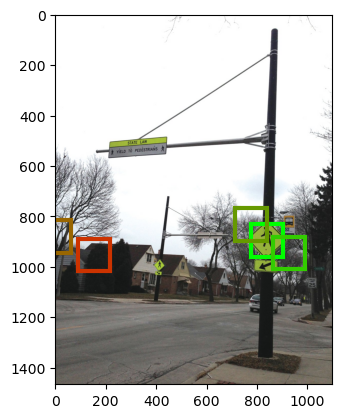

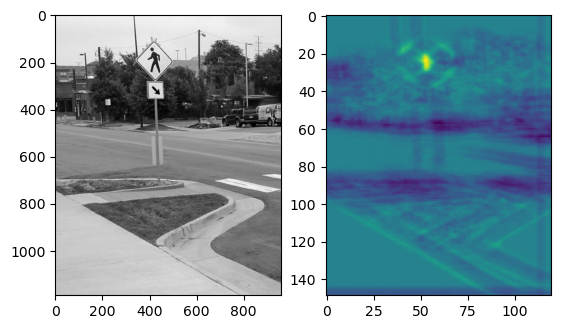

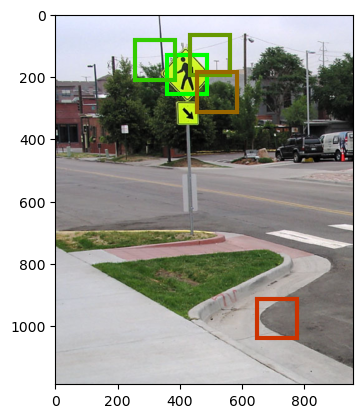

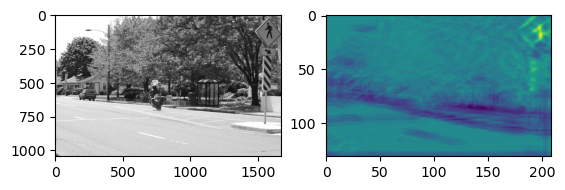

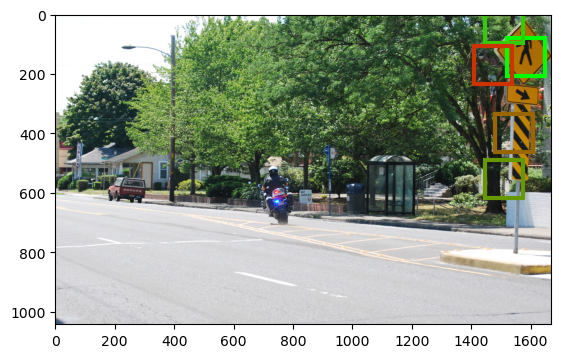

In [42]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('apos1.jpg','apos2.jpg','apos3.jpg','apos4.jpg','apos5.jpg')
negfiles = ('aneg1.jpg','aneg2.jpg','aneg3.jpg','aneg4.jpg','aneg5.jpg')


# call learn_template to learn and visualize the template and training data
template=learn_template(posfiles,negfiles,tsize=tsize)

template = resize(template, fmap.shape, anti_aliasing=True)

# normelizing
template = (template - np.mean(template)) / (np.std(template) + 1e-6)

#im_test = plt.imread('test3.jpg')
  
# call detect on one or more test images, visualizing the result with the plot_detections function
# resizing the image
#im_test = resize(im_test, (1024, 1024), anti_aliasing=True)


#detections = detect(im_test, template)


#plot_detections(im_test,detections,tsize_pix)


for i in range(5):
    im_test = plt.imread("test" + str(i+1) + ".jpg").astype(float)/255
    detections = detect(im_test,template)
    plot_detections(im_test,detections,tsize_pix)


Discution: the functions work well on normal faces and without nessessry facial expretions becaseu we do not have a template for the faces with smiles, anger and etc. Also when people are really close to each other it is harder to rececnize the faces and even they detected with red lines, also when the faces is inverted they would not get regecnized at all. 

# 6. Detection with convolutional neural net (CNN) features [20pts]

In [43]:
pip install torch torchvision

In this final part of the assignment, we will swap out the HOG features for a different featuremap computed using a Convolutional Neural Network (CNN) that has been pre-trained to classify ImageNet categories.

First you will need to install pytorch, typically via "pip3 install torch torchvision"
(see https://pytorch.org/get-started/locally/ for more details). We will run the code on cpu so you shouldn't have to worry about gpu drivers (unless you want to).

The code below loads the pretrained model and defines a function ***extractfeatures*** which performs the same functionality as your ***hog*** function but using the pretrained CNN.  With the default settings, the function takes a (HxWx3) color image and returns an (H/16,W/16,256) feature map as output. The spatial cells are bigger than HOG (16x16 vs 8x8 pixels) so there is lower spatial resolution but the feature dimension much larger (256 vs 8).

Your job is to write ***learn_template_cnn*** and ***detect_cnn*** which use this feature map instead of HOG. These functions are almost identical so you should probably start with a copy of the corresponding functions you've written for HOG and modify them appropriately (e.g. nchannels plays the role of norient for HOG)

Once you've written these two functions, run the demo code for the face example with these new features. You should see improved performance relative to HOG. Give a brief description of any systematic changes you see between the two.

Things to keep in mind:
* The CNN takes color images as input rather than grayscale
* When building a template from a cropped example, boundary effects in the CNN play a big role. To manage this, we pad the training examples before extracting the features when learning the template in order to minimize those effects


In [44]:
import torch
import torchvision  
from PIL import Image
device = "cpu"

In [45]:
#load a ResNet18 model which was pretrained on ImageNet classification
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
#we won't train the model weights so we don't need to store gradient 
#info when we run the model
for param in model.parameters():
    param.requires_grad = False
    
layerid = 'layer3'
bsize = 16           #block size for resnet18.layer3 features
nchannels = 256
tsize=np.array([8,8]) #this is same size (in pixels) as our default HOG template

### corresponding sizes for other layer feature maps in ResNet18
#layerid='layer4' // bsize=32 // nchannels = 512 //tsize=np.array([4,4]) 
#layerid='layer2' // bsize = 8 // nchannels = 128 //tsize=np.array([16,16]) 

#register a function with the pytorch network that makes a copy of the features
# during the forward pass.
featuremap = {}
def get_hook(layername):
    def hook(model, input, output):
        featuremap[layername] = output.detach()
    return hook
    
model.layer3.register_forward_hook(get_hook(layerid))

In [46]:
def extractfeatures(img,model,layerid='layer3',pad=False,padval=1):
    
    """
    This function takes a color image and returns a 3D array
    containing the ResNet layer 3 feature map extracted from the image.
    
    Parameters
    ----------
    image : 3D float array of shape HxWx3
         An array containing pixel RGB values in [0,1]
    
    model : a pytorch resnet18 model

    layerid : str
        the name of the layer to extract from the model,
        default layer3 has bsize=16 and nchannels=256

    pad : bool
        pad the image before extracting features, default False

    padval : float 
        gray value to fill in the border region. 0=black, 1=white
    
    Returns
    -------
    f : 3D float array of shape (H/bsize,W/bsize,nchannels)
        CNN feature map.
        
    """   
 
    # make sure we have floats in [0,1]
    if (img.dtype == np.uint8):
        img = img.astype(float) / 255

    (h,w,c) = img.shape
    # if image is RGBA, drop the alpha channel
    if (c>3):
        img = img[:,:,0:3]

    # If choose to, pad the imput image by surrounding it with
    # a white border that is the same width as the input image
    # Ths will avoid some boundary effects of the CNN
    if pad:
        im = padval*np.ones((3*h,3*w,3),dtype=float)
        im[h:2*h,w:2*w,:] = img
    else:   
        im = img

    #normalize range of values to match resnet training and convert to a torch float32 tensor
    im = (im - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    imt = torch.from_numpy(im)
    imt = imt.to(dtype=torch.float32)
 
    #put channels first to match pytorch convention
    imt = imt.permute(2,0,1)
    #add in an extra leading dimension so the shape will now be (1,3,h,w)
    imt = imt.unsqueeze(0)

    #if using gpu, move from memory to device and run the model
    imt = imt.to(device)
    model = model.to(device)
    with torch.no_grad():
        output = model(imt)

    #grab the result back and premute back to our numpy representation (h,w,nchannels)
    f = featuremap[layerid].cpu()
    f = f[0,:,:,:]
    f = f.permute(1,2,0)
    f = f.numpy()

    #if we padded the boundary, crop back off the feature map 
    #corresponding to the border.
    if pad:
        (fh,fw,fc) = f.shape
        fhi = np.round(fh/3).astype('int')
        fwi = np.round(fw/3).astype('int')
        f = f[fhi:2*fhi,fwi:2*fwi]
    
    return f

## Fill out the implementation for the two functions below:

In [47]:
def learn_template_cnn(posfiles,negfiles,model,tsize=np.array([4,4]),bsize=32,nchannels=512):
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a CNN feature template and generates 
    visualization of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks

    bsize : int
        The size of the block in pixels

    nchannels : int
        Number of feature channels
        
    Returns
    -------
    template : float array of size tsize x nchannels
        The learned CNN feature template
    
    """ 
    
    #compute the template size in pixels 
    #corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    #accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0],tsize[1],nchannels),dtype=float) 

    fig1 = plt.figure(figsize=(10, len(posfiles)*2))
    pltct = 1

    for file in posfiles:
        #load in a cropped positive example
        img = np.array(Image.open(file).convert('RGB')) / 255.0

        #convert to grayscale float in [0,1] and resize to fixed dimension tsize_pix
        #using skimage.transform.resize 

        if (img.dtype == np.uint8):
            img = img.astype(float) / 255

        
        img_scaled =  resize(img, (tsize_pix[0], tsize_pix[1]), anti_aliasing=True)
        
        #display the example. if you want to train with a large # of examples, 
        #you may want to modify this, e.g. to show only the first 5.
        ax = fig1.add_subplot(len(posfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature, set pad=True so that we pad the image before computing the CNN feature map
        fmap = extractfeatures(img_scaled,model)
 
        #compute running average
        pos_t +=fmap

    pos_t /= len(posfiles) 
    fig1.show()

    fig2=plt.figure(figsize=(10, len(posfiles)*2))
    pltct=1

    neg_t=np.zeros((tsize[0],tsize[1],nchannels),dtype=float) 

    for file in negfiles:
        img = np.array(Image.open(file).convert('RGB')) / 255.0

        #convert to grayscale float in [0,1] and resize to fixed dimension tsize_pix
        #using skimage.transform.resize 

        if (img.dtype == np.uint8):
            img = img.astype(float) / 255

        img_scaled =  resize(img, (tsize_pix[0], tsize_pix[1]), anti_aliasing=True)

        ax = fig1.add_subplot(len(posfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1

        fmap = extractfeatures(img_scaled,model)
 
        #compute running average
        neg_t +=fmap


    neg_t /= len(negfiles) 
    fig2.show()

     #....etc....
        

    return pos_t - neg_t


In [48]:
def detect_cnn(image,template,model,ndetect=5,bsize=32,nchannels=512):
    
    """
    This function takes a color image and a template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : a 3D float array 
        CNN template we wish to match to the image
        
    ndetect : int
        Number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    nchannels : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
        
    """ 
    
    #visualize the input image and score response map
    vis=True
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==nchannels)
    
    fmap = extractfeatures(image,model)
    
    
    #cross-correlate the template with the feature map to get the total response
    resp = np.zeros((fmap.shape[0],fmap.shape[1]))
    for i in range(nchannels):
        resp = resp + ndimage.correlate(fmap[:, :, i], template[:, :, i], mode='constant')


    detections = []
    for _ in range(ndetect):
        y, x = np.unravel_index(np.argmax(resp), resp.shape)
        detections.append((x * bsize, y * bsize, resp[y, x]))
        resp[y, x] = -np.inf  # Suppress this detection

    if vis:
        plt.subplot(1,2,1)
        plt.imshow(image,cmap=plt.get_cmap('gray'))
        plt.subplot(1,2,2)
        plt.imshow(resp)
        plt.show()

    #....etc....

    return detections
    

## Results
Please run the following code to visualize the results on the face dataset.  In the cell below, discuss how the results compare to HOG.

C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\554522846.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\arshi\AppData\Local\Temp\ipykernel_9592\554522846.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


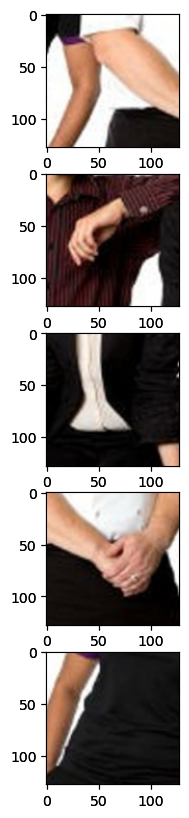

<Figure size 1000x1000 with 0 Axes>

In [49]:
# train and test a model
bsize = 16           #block size for resnet18.layer3 features
nchannels = 256
tsize=np.array([8,8]) #this is same size (in pixels) as our default HOG template
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos1.jpg','pos2.jpg','pos3.jpg','pos4.jpg','pos5.jpg')
negfiles = ('neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg')
#path = 'patches/'
#posfiles = [path+str for str in posfiles]
#negfiles = [path+str for str in negfiles]

# call learn_template to learn and visualize the template and training data
template = learn_template_cnn(posfiles,negfiles,model,tsize=tsize,bsize=bsize,nchannels=nchannels)


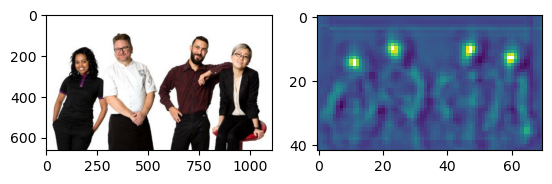

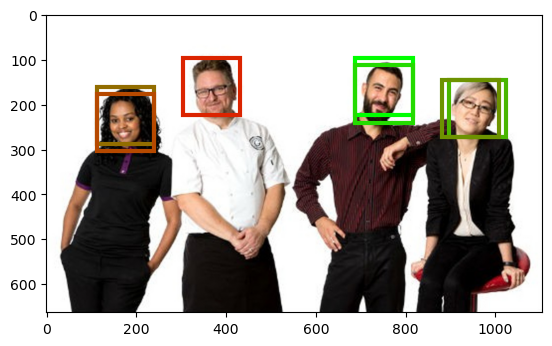

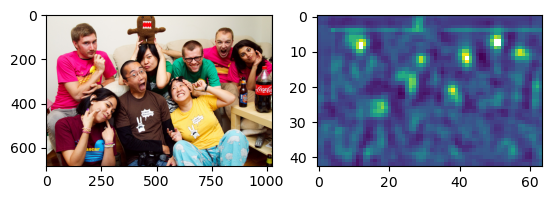

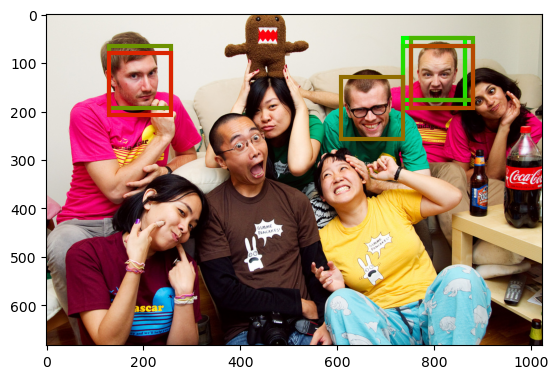

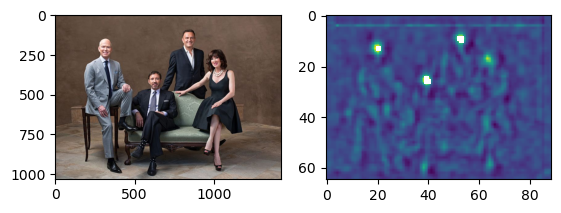

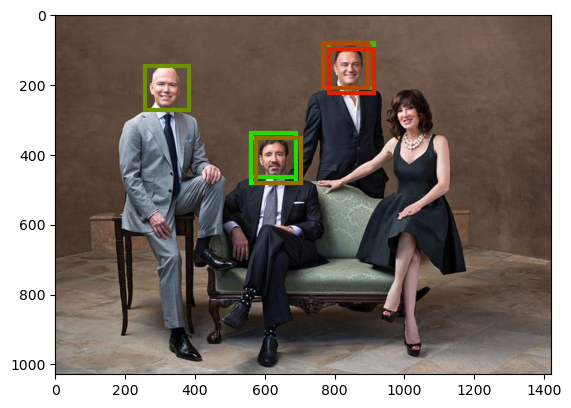

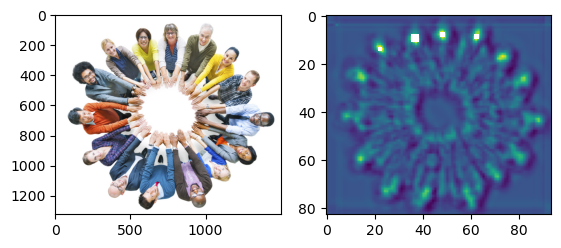

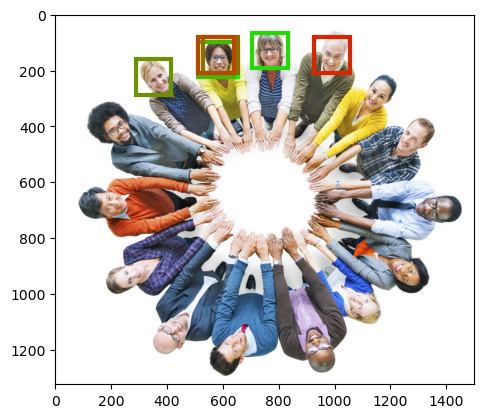

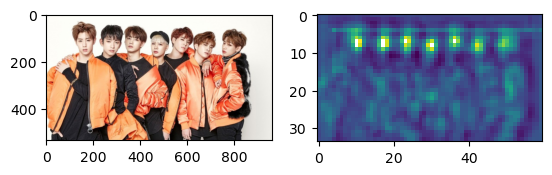

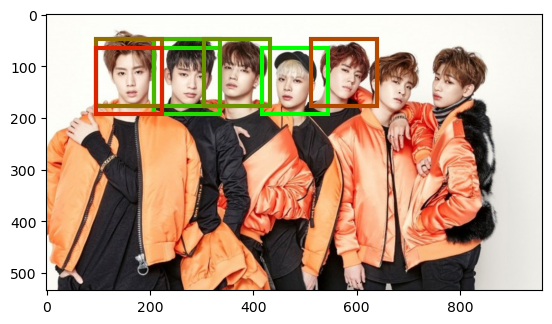

In [50]:
# call detect on one or more test images, visualizing the result with the plot_detections function
for i in range(5):
    testim = plt.imread("faces" + str(i+1) + ".jpg").astype(float)/255
    detections = detect_cnn(testim,template,model,ndetect=7,bsize=bsize,nchannels=nchannels)
    plot_detections(testim,detections,tsize_pix)


## [your discussion here] The faces that are much more closer together are much more detectable and it also would not mistake the brown dull but there are still problems like cannot rececnize faces with smiles or goofy faces and also it cannot rececnize inverted faces.